## <strong>RelTR Online Demo</strong>

This is a online notebook that shows how RelTR model detects a fixed-length set of relationships given an image. The loaded checkpoint is pretrained on Visual Genome-150.

# Installation
Install RelTR and import necessary packages.

In [1]:
!git clone https://github.com/yrcong/RelTR.git
%cd RelTR/
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image
import requests
import matplotlib.pyplot as plt

Cloning into 'RelTR'...
remote: Enumerating objects: 317, done.
remote: Counting objects: 100% (317/317), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 317 (delta 140), reused 282 (delta 120), pack-reused 0
Receiving objects: 100% (317/317), 27.49 MiB | 30.07 MiB/s, done.
Resolving deltas: 100% (140/140), done.
/content/RelTR


# VG labels
VG 150 enitiy classes and 50 relationship classes.

In [2]:
CLASSES = [ 'N/A', 'airplane', 'animal', 'arm', 'bag', 'banana', 'basket', 'beach', 'bear', 'bed', 'bench', 'bike',
                'bird', 'board', 'boat', 'book', 'boot', 'bottle', 'bowl', 'box', 'boy', 'branch', 'building',
                'bus', 'cabinet', 'cap', 'car', 'cat', 'chair', 'child', 'clock', 'coat', 'counter', 'cow', 'cup',
                'curtain', 'desk', 'dog', 'door', 'drawer', 'ear', 'elephant', 'engine', 'eye', 'face', 'fence',
                'finger', 'flag', 'flower', 'food', 'fork', 'fruit', 'giraffe', 'girl', 'glass', 'glove', 'guy',
                'hair', 'hand', 'handle', 'hat', 'head', 'helmet', 'hill', 'horse', 'house', 'jacket', 'jean',
                'kid', 'kite', 'lady', 'lamp', 'laptop', 'leaf', 'leg', 'letter', 'light', 'logo', 'man', 'men',
                'motorcycle', 'mountain', 'mouth', 'neck', 'nose', 'number', 'orange', 'pant', 'paper', 'paw',
                'people', 'person', 'phone', 'pillow', 'pizza', 'plane', 'plant', 'plate', 'player', 'pole', 'post',
                'pot', 'racket', 'railing', 'rock', 'roof', 'room', 'screen', 'seat', 'sheep', 'shelf', 'shirt',
                'shoe', 'short', 'sidewalk', 'sign', 'sink', 'skateboard', 'ski', 'skier', 'sneaker', 'snow',
                'sock', 'stand', 'street', 'surfboard', 'table', 'tail', 'tie', 'tile', 'tire', 'toilet', 'towel',
                'tower', 'track', 'train', 'tree', 'truck', 'trunk', 'umbrella', 'vase', 'vegetable', 'vehicle',
                'wave', 'wheel', 'window', 'windshield', 'wing', 'wire', 'woman', 'zebra']

REL_CLASSES = ['__background__', 'above', 'across', 'against', 'along', 'and', 'at', 'attached to', 'behind',
                'belonging to', 'between', 'carrying', 'covered in', 'covering', 'eating', 'flying in', 'for',
                'from', 'growing on', 'hanging from', 'has', 'holding', 'in', 'in front of', 'laying on',
                'looking at', 'lying on', 'made of', 'mounted on', 'near', 'of', 'on', 'on back of', 'over',
                'painted on', 'parked on', 'part of', 'playing', 'riding', 'says', 'sitting on', 'standing on',
                'to', 'under', 'using', 'walking in', 'walking on', 'watching', 'wearing', 'wears', 'with']


# Build and load the pretrained model

In [3]:
from models.backbone import Backbone, Joiner
from models.position_encoding import PositionEmbeddingSine
from models.transformer import Transformer
from models.reltr import RelTR

position_embedding = PositionEmbeddingSine(128, normalize=True)
backbone = Backbone('resnet50', False, False, False)
backbone = Joiner(backbone, position_embedding)
backbone.num_channels = 2048

transformer = Transformer(d_model=256, dropout=0.1, nhead=8,
                          dim_feedforward=2048,
                          num_encoder_layers=6,
                          num_decoder_layers=6,
                          normalize_before=False,
                          return_intermediate_dec=True)

model = RelTR(backbone, transformer, num_classes=151, num_rel_classes = 51,
              num_entities=100, num_triplets=200)

# The checkpoint is pretrained on Visual Genome
ckpt = torch.hub.load_state_dict_from_url(
    url='https://cloud.tnt.uni-hannover.de/index.php/s/PB8xTKspKZF7fyK/download/checkpoint0149.pth',
    map_location='cpu', check_hash=True)
model.load_state_dict(ckpt['model'])
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 52.0MB/s]
Downloading: "https://cloud.tnt.uni-hannover.de/index.php/s/PB8xTKspKZF7fyK/download/checkpoint0149.pth" to /root/.cache/torch/hub/checkpoints/checkpoint0149.pth
731MB [00:27, 27.5MB/s]


RelTR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn_entity): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features

In [4]:
# Some transformation functions
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
          (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

# Load Image
You can replace the link with other images. Note that the entities in the used image should be included in the VG labels.

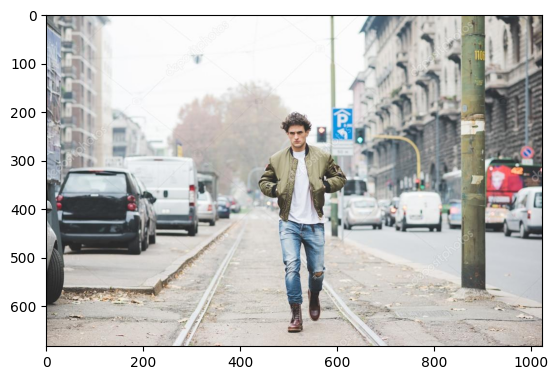

In [24]:
# url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Yellow_Happy.jpg/1200px-Yellow_Happy.jpg'
url = "https://st2.depositphotos.com/1034986/11789/i/950/depositphotos_117893698-stock-photo-man-walking-in-street-of.jpg"
im = Image.open(requests.get(url, stream=True).raw)
plt.imshow(im)
img = transform(im).unsqueeze(0)

# Inference

In [25]:
# propagate through the model
outputs = model(img)

# keep only predictions with >0.1 confidence
probas = outputs['rel_logits'].softmax(-1)[0, :, :-1]
probas_sub = outputs['sub_logits'].softmax(-1)[0, :, :-1]
probas_obj = outputs['obj_logits'].softmax(-1)[0, :, :-1]
keep = torch.logical_and(probas.max(-1).values > 0.1, torch.logical_and(probas_sub.max(-1).values > 0.1,
                                                                        probas_obj.max(-1).values > 0.1))

In [26]:
len(keep)

keep

tensor([False, False, False, False, False, False, False, False,  True, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False,  True, False, False, False, False,
        False,  True, False, False, False,  True, False,  True, False, False,
        False,  True, False, False, False,  True, False,  True, False, False,
        False, False,  True,  True, False, False, False,  True, False, False,
         True, False, False, False, False, False, False,  True, False,  True,
        False,  True, False, False, False, False, False,  True, False, False,
        False,  True, False, False,  True, False, False,  True,  True,  True,
         True,  True, False, False, False, False, False, False,  True, False,
        False, False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, 

In [27]:
# convert boxes from [0; 1] to image scales
sub_bboxes_scaled = rescale_bboxes(outputs['sub_boxes'][0, keep], im.size)
obj_bboxes_scaled = rescale_bboxes(outputs['obj_boxes'][0, keep], im.size)

topk = 10 # display up to 10 images
keep_queries = torch.nonzero(keep, as_tuple=True)[0]
indices = torch.argsort(-probas[keep_queries].max(-1)[0] * probas_sub[keep_queries].max(-1)[0] * probas_obj[keep_queries].max(-1)[0])[:topk]
keep_queries = keep_queries[indices]

In [28]:
keep_queries

tensor([ 81,  77, 112,  99, 101, 100,  57, 143, 181,  94])

In [29]:
indices

tensor([16, 14, 26, 22, 24, 23,  9, 31, 38, 19])

In [30]:
# save the attention weights
conv_features, dec_attn_weights_sub, dec_attn_weights_obj = [], [], []
hooks = [
    model.backbone[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
    model.transformer.decoder.layers[-1].cross_attn_sub.register_forward_hook(
        lambda self, input, output: dec_attn_weights_sub.append(output[1])
    ),
    model.transformer.decoder.layers[-1].cross_attn_obj.register_forward_hook(
        lambda self, input, output: dec_attn_weights_obj.append(output[1])
    )]

In [31]:
outputs.keys()

dict_keys(['pred_logits', 'pred_boxes', 'sub_logits', 'sub_boxes', 'obj_logits', 'obj_boxes', 'rel_logits'])

In [32]:
for val in outputs.keys():
    print(val, len(outputs[val][0]))

pred_logits 100
pred_boxes 100
sub_logits 200
sub_boxes 200
obj_logits 200
obj_boxes 200
rel_logits 200


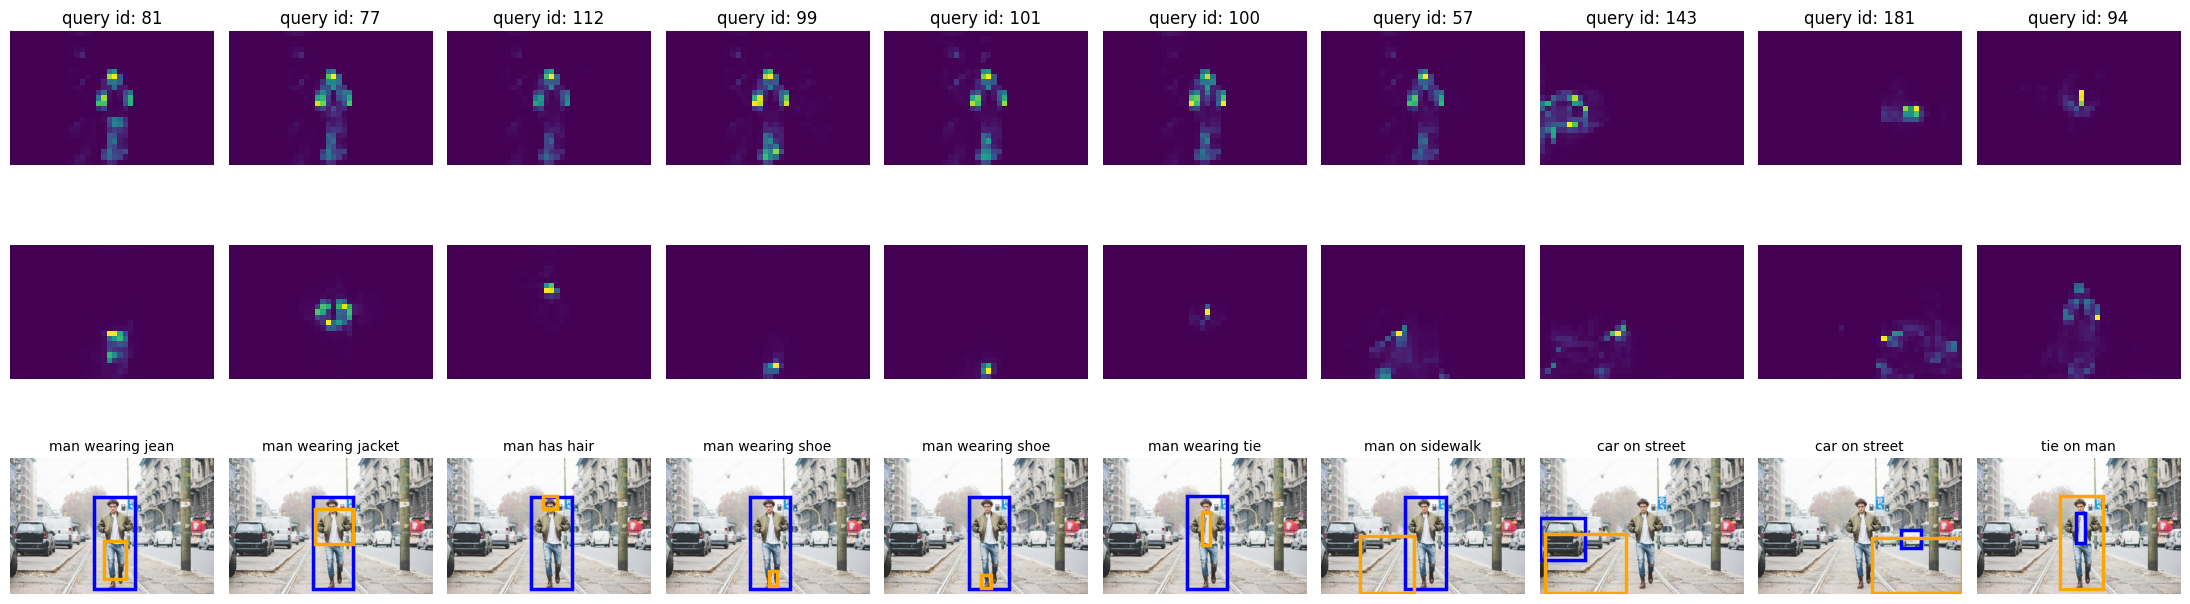

In [33]:
with torch.no_grad():
    # propagate through the model
    outputs = model(img)

    for hook in hooks:
        hook.remove()

    # don't need the list anymore
    conv_features_1 = conv_features[0]
    dec_attn_weights_sub = dec_attn_weights_sub[0]
    dec_attn_weights_obj = dec_attn_weights_obj[0]

    # get the feature map shape
    h, w = conv_features_1['0'].tensors.shape[-2:]
    im_w, im_h = im.size

    fig, axs = plt.subplots(ncols=len(indices), nrows=3, figsize=(22, 7))
    for idx, ax_i, (sxmin, symin, sxmax, symax), (oxmin, oymin, oxmax, oymax) in \
            zip(keep_queries, axs.T, sub_bboxes_scaled[indices], obj_bboxes_scaled[indices]):
        ax = ax_i[0]
        ax.imshow(dec_attn_weights_sub[0, idx].view(h, w))
        ax.axis('off')
        ax.set_title(f'query id: {idx.item()}')
        ax = ax_i[1]
        ax.imshow(dec_attn_weights_obj[0, idx].view(h, w))
        ax.axis('off')
        ax = ax_i[2]
        ax.imshow(im)
        ax.add_patch(plt.Rectangle((sxmin, symin), sxmax - sxmin, symax - symin,
                                    fill=False, color='blue', linewidth=2.5))
        ax.add_patch(plt.Rectangle((oxmin, oymin), oxmax - oxmin, oymax - oymin,
                                    fill=False, color='orange', linewidth=2.5))

        ax.axis('off')
        ax.set_title(CLASSES[probas_sub[idx].argmax()]+' '+REL_CLASSES[probas[idx].argmax()]+' '+CLASSES[probas_obj[idx].argmax()], fontsize=10)

    fig.tight_layout()
    plt.show()